In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical colummn and see what happens off of this kind of naive approach.

In [4]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
#X = pd.get_dummies(X)

#cross_val_score(rfc, X, Y, cv=5)

Did your kernel die? My kernel died.

Guess it isn't always going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!)

## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [5]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [6]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [7]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]
y2015.shape

(421095, 103)

Now this should be better. Let's try again.

In [9]:
dummies=pd.get_dummies(y2015) # get_dummies converts categorical features into numerics
dummies.shape


(421095, 237)

It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [10]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

print("X:",type(X),X.head())
print("Y:",type(Y),Y.head())

#cross_val_score(rfc, X, Y, cv=10)

X: <class 'pandas.core.frame.DataFrame'>            id   member_id  loan_amnt  funded_amnt  funded_amnt_inv  int_rate  \
0  68009401.0  72868139.0    16000.0      16000.0          16000.0     14.85   
1  68354783.0  73244544.0     9600.0       9600.0           9600.0      7.49   
2  68466916.0  73356753.0    25000.0      25000.0          25000.0      7.49   
3  68466961.0  73356799.0    28000.0      28000.0          28000.0      6.49   
4  68495092.0  73384866.0     8650.0       8650.0           8650.0     19.89   

   installment  annual_inc    dti  delinq_2yrs  \
0       379.39     48000.0  33.18          0.0   
1       298.58     60000.0  22.44          0.0   
2       777.55    109000.0  26.02          0.0   
3       858.05     92000.0  21.60          0.0   
4       320.99     55000.0  25.49          0.0   

                  ...                  last_credit_pull_d_Nov-2016  \
0                 ...                                            0   
1                 ...                

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know

### RFC - when missing data is removed

In [11]:
# How much data is missing in the target column
print('Unique of features:', y2015['loan_status'].unique())
print('Sum of missing datapoints for loan_status', y2015['loan_status'].isnull().sum())

Unique of features: ['Current' 'Fully Paid' 'Charged Off' 'Late (31-120 days)'
 'In Grace Period' 'Default' 'Late (16-30 days)']
Sum of missing datapoints for loan_status 0


No data is missing in the target column. That is good.

In [12]:
# Drop all columns that contain NA
y2015NoNa = y2015.dropna(axis=1)
print(y2015.shape)
print(y2015NoNa.shape)
#Check if 'loan_status' is still in columns
print('loan_status' in y2015NoNa.columns)

(421095, 103)
(421095, 68)
True


In [13]:
# Split data into categorical and numerical
y2015NoNa_num = y2015NoNa._get_numeric_data()
print(y2015NoNa_num.shape)
# scale numeric data
from sklearn.preprocessing import StandardScaler
y2015NoNa_num_scaled = StandardScaler().fit_transform(y2015NoNa_num)
y2015_num_scaled = pd.DataFrame(y2015NoNa_num_scaled, columns = y2015NoNa_num.columns)

# Drpp numeric data columns
y2015NoNa_cat = y2015NoNa.drop(y2015NoNa_num.columns, axis=1)
print(y2015NoNa_cat.shape)

# generate dummies for categorical data
y2015_catdum= pd.get_dummies(y2015NoNa_cat)
print(y2015_catdum.shape)

(421095, 58)
(421095, 10)
(421095, 54)


In [14]:
# rejoin the dataset
scD= y2015_num_scaled.join(y2015NoNa_cat)
scD.shape

(421095, 68)

In [15]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import time
def crossval(input_df, target, no_folds):
    start_time=time.time()
    rand_forest_class = ensemble.RandomForestClassifier()
    cvs = cross_val_score(rand_forest_class, input_df, target, cv=no_folds)
    print(cvs)    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    return(cvs)

In [16]:
#Data
target= scD['loan_status']
data=scD.drop('loan_status', axis=1)
datDum = pd.get_dummies(data)

#Run Randon Forest Classifier
NoNaScores =crossval(datDum, target, 10)

[0.96081784 0.96452233 0.96138776 0.96105531 0.9591071  0.95877464
 0.79581562 0.96031727 0.96029164 0.95549328]
Time taken: 355.119 seconds.
Average accuracy: 0.944


### RFC - with PCA

In [17]:
#Function to run PCA and RFC
from matplotlib.mlab import PCA as mlabPCA
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

def PCAandRFC(input_df,no_cs, target, no_folds):
    
    pca = PCA(n_components=no_cs)
    Y_sklearn = pca.fit_transform(input_df) # Makes the whole PCA
    print(
        'The percentage of total variance in the dataset explained by each',
        'component from Sklearn PCA.\n',
        pca.explained_variance_ratio_
    )

    var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    plt.plot(var1)
    plt.show()
    # Select the components
    PCA_Features = pd.DataFrame(Y_sklearn)
    # Use the components to run RFC  
    PCAScores=crossval(PCA_Features, target, no_folds)
    return(PCAScores)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.16752381 0.09791158 0.05869457 0.05721646 0.05151462 0.03831797
 0.03534651 0.03374542 0.03057518 0.0291266 ]


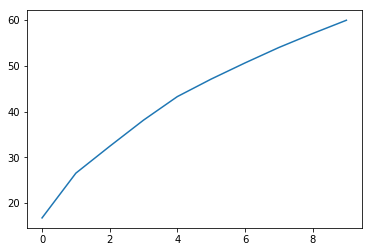

[0.88632424 0.89898126 0.89985989 0.90026359 0.89693659 0.88997863
 0.88218671 0.88306538 0.89296317 0.814017  ]
Time taken: 438.159 seconds.
Average accuracy: 0.884


In [18]:
PCAScores10=PCAandRFC(datDum,10, target, 10)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.16752381 0.09791158 0.05869457 0.05721646 0.05151462 0.03831798
 0.03534659 0.03374544 0.03057539 0.02912695 0.02870825 0.02190484
 0.01993514 0.01799992 0.01767637 0.01654966 0.01616469 0.01606871
 0.01577781 0.01516421 0.01404567 0.01364271 0.01351596 0.01190054
 0.01160556 0.01125123 0.01000285 0.00861104 0.00800378 0.00761584
 0.00730304 0.00621679 0.00586718 0.00575206 0.00551713 0.00516091
 0.00434039 0.00427907 0.00391131 0.00383868 0.00347125 0.00344973
 0.003215   0.00312943 0.00302617 0.00236961 0.00230628 0.00207655
 0.0019041  0.00184388 0.00183141 0.00172364 0.00155314 0.00152156
 0.0013995  0.00138669 0.00134722 0.00131878 0.00126582 0.00115536
 0.00112668 0.0011143  0.00105916 0.00105213 0.00094646 0.00079614
 0.00070241 0.00060171 0.00044345 0.00043395]


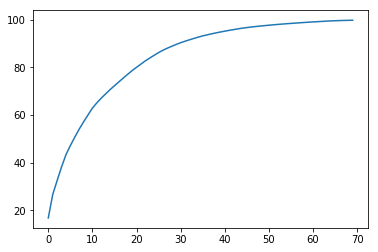

[0.88309468 0.90126095 0.88922134 0.89553798 0.87872239 0.8888625
 0.74072051 0.84345389 0.69302016 0.7200874 ]
Time taken: 1129.614 seconds.
Average accuracy: 0.833


In [19]:
PCAScores30=PCAandRFC(datDum,70, target, 10)

### RFC with most correlated features

In [20]:
# join numerical and dummy data inlcuding the loan status
corrdata= y2015_num_scaled.join(y2015_catdum)
corrdata.shape

(421095, 112)

In [21]:
# See which features correlated with the target
CorrMa = corrdata.corr(method='pearson')

In [22]:
#Column names that include loan_status
Features=pd.get_dummies(target).columns.tolist()

In [23]:
FeaturesC = ['loan_status_' + s  for s in Features]
print(FeaturesC)

['loan_status_Charged Off', 'loan_status_Current', 'loan_status_Default', 'loan_status_Fully Paid', 'loan_status_In Grace Period', 'loan_status_Late (16-30 days)', 'loan_status_Late (31-120 days)']


In [24]:
# Look at best correlated features
CorrMa[FeaturesC].head()

,loan_status_Charged Off,loan_status_Current,loan_status_Default,loan_status_Fully Paid,loan_status_In Grace Period,loan_status_Late (16-30 days),loan_status_Late (31-120 days)
id,-0.083406,0.146429,0.004373,-0.119724,-0.000731,0.005020,0.008371
member_id,-0.083382,0.146156,0.004429,-0.119457,-0.000748,0.005096,0.008412
loan_amnt,0.011895,0.015382,0.001988,-0.033211,0.011779,0.009891,0.009339
funded_amnt,0.011895,0.015382,0.001988,-0.033211,0.011779,0.009891,0.009339
funded_amnt_inv,0.011844,0.015401,0.001965,-0.033178,0.011769,0.009872,0.009298


In [25]:
CorrMa['Sum_LoanStatus']=CorrMa[FeaturesC].sum(axis=1)
CorrMa['Sum_LoanStatus'].head(5)

id                -0.039670
member_id         -0.039494
loan_amnt          0.027063
funded_amnt        0.027063
funded_amnt_inv    0.026972
Name: Sum_LoanStatus, dtype: float64

In [26]:
# Return the most positively and negatively correlated features 
CorrMa['abs_Sum_LoanStatus']=abs(CorrMa['Sum_LoanStatus'])
CorrMa=CorrMa.sort_values(by='abs_Sum_LoanStatus', ascending=False)
CorrMa['Sum_LoanStatus'].head(20)

loan_status_Default               0.887982
loan_status_Late (16-30 days)     0.828841
loan_status_In Grace Period       0.743873
loan_status_Current              -0.688066
loan_status_Late (31-120 days)    0.625224
loan_status_Charged Off           0.360243
int_rate                          0.227989
total_rec_late_fee                0.176385
collection_recovery_fee           0.167451
recoveries                        0.166772
grade_A                          -0.131174
total_rec_prncp                  -0.123815
acc_open_past_24mths              0.119297
num_tl_op_past_12m                0.107263
grade_E                           0.106415
grade_F                           0.093645
total_pymnt_inv                  -0.092828
total_pymnt                      -0.092797
grade_D                           0.091356
grade_B                          -0.090202
Name: Sum_LoanStatus, dtype: float64

hardly any feature is correlated...

In [27]:
# planned to choose all features with abs(R^2)>0.5, but there are none. 
# the remaining features are barely correlated with the target.
# Therefore I chose to use the top 20 and remove the loan_status features

topFeatures= CorrMa.index.tolist()[0:20]
print(len(topFeatures))
topFeaturesnew=[]
#check if topFeature contain loan_status feature
for f in topFeatures:
    if f in FeaturesC:
        next
    else:
        print(f)
        topFeaturesnew.append(f) # append only with elements that are not element of the target

print(len(topFeaturesnew))

20
int_rate
total_rec_late_fee
collection_recovery_fee
recoveries
grade_A
total_rec_prncp
acc_open_past_24mths
num_tl_op_past_12m
grade_E
grade_F
total_pymnt_inv
total_pymnt
grade_D
grade_B
14


In [30]:
# Repeat RFC with the most correlated features
#Data
target= scD['loan_status']
data=scD.drop('loan_status', axis=1)
datDum = pd.get_dummies(data)
print(datDum.shape)
datDum= datDum[topFeaturesnew]
print(datDum.shape)
#Randon Forest Classifier
CorScores=crossval(datDum, target, 10)

(421095, 105)
(421095, 14)
[0.89093111 0.90667522 0.90301821 0.9060578  0.91104251 0.91175493
 0.91184782 0.91389014 0.91455102 0.88533701]
Time taken: 122.855 seconds.
Average accuracy: 0.906


In [31]:
print(CorScores)

[0.89093111 0.90667522 0.90301821 0.9060578  0.91104251 0.91175493
 0.91184782 0.91389014 0.91455102 0.88533701]


## Conclusion



   NoNaScore  PCAScore10  PCAScore70  CorrScores
0   0.960818    0.886324    0.883095    0.890931
1   0.964522    0.898981    0.901261    0.906675
2   0.961388    0.899860    0.889221    0.903018
3   0.961055    0.900264    0.895538    0.906058
4   0.959107    0.896937    0.878722    0.911043
      NoNa    PCA10     PCA70     Corr
0  332.545  324.077  1047.659  121.029


Text(0.5,0,'Variations tried')

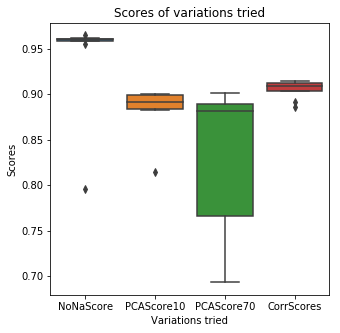

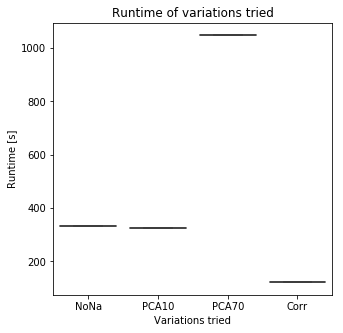

In [35]:
Scores = {'NoNaScore': NoNaScores, 'PCAScore10': PCAScores10, 'PCAScore70': PCAScores30,'CorrScores': CorScores}
RunTimes={'NoNa':[332.545] , 'PCA10': [324.077], 'PCA70': [1047.659], 'Corr': [121.029]}
Scoreresults = pd.DataFrame(data=Scores, index=(range(10)))
print(Scoreresults.head())
Timeresults=pd.DataFrame(data=RunTimes)
print(Timeresults)

# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
im = sns.boxplot(data=Scoreresults[['NoNaScore','PCAScore10','PCAScore70','CorrScores']], ax=ax)
im.set_title('Scores of variations tried')
im.set_ylabel('Scores')
im.set_xlabel('Variations tried')
# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
im = sns.boxplot(data=Timeresults[['NoNa','PCA10','PCA70','Corr']], ax=ax)
im.set_title('Runtime of variations tried')
im.set_ylabel('Runtime [s]')
im.set_xlabel('Variations tried')

The best scores are received when the data is cleaned from all columns that contain Na. However, the scores might be overfitting as there is one extreme outlier in the othwise very tigh distribution of errors.
When using principal components for the RFC, the score drops to 90% accurancy, with equal or even longer running times. So this method does not seem to be a good alternative here.
When summing the correlation scores for the loan_status data and using the best 14 features, that really have low correlation with the output features, we also achieve an average accuracy of 90% combined with a fast runtime.  
